# Getting Started with the Trends API

This notebook serves as a tutorial for the Trends endpoint in the Signal AI API.

Full technical documentation of the Trends endpoint is available here
https://api.signal-ai.com/docs#tag/Trends


## Trends API Overview

The Trends API provides at-a-glance aggregated metrics over all news & regulatory content available in our Platform. It supports analysing our content accross multiple dimensions, and enables users to monitor, visualise and understand information such as the following:
- Changes in sentiment for an entity over time
- Sentiment for an entity in relation to a set of key topics
- News coverage and sentiment around an entity in different locations
- Difference in coverage and sentiment between entities over time and in relation to different topics

## 0. Setting things up!

### 0.1 Pre-requisites

Please make sure that you have familiarised yourself with the Signal AI API using the [Getting Started notebook](getting_started.ipynb)

In particular you would need to be able to use the following endpoints:

- Authentication: to be able to access the API
- Discovery: to be able to search for entities and topics of interest


Note: run `pip install -r requirements.txt` to install the dependencies for this notebook

In [1]:
import requests
import os
import pandas as pd
import numpy as np
import json
from pandas import json_normalize

### 0.2 Check if authentication works!

You will need a client_id and client_secret to gain access to the API. The code below will assume they have been set and the environment variables `SIGNAL_API_CLIENT_ID` and `SIGNAL_API_CLIENT_SECRET` respectively.

Using your credentials you can request a temporary access token from the API using the url: https://api.signal-ai.com/auth/token


In [2]:
def authenticate(client_id, client_secret, url = "https://api.signal-ai.com"):
    """ obtain a temporary access token using user credentials """
    token_url = f'{url}/auth/token'
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(token_url, data=payload)
    return response.json().get("access_token")

In [3]:
TEMP_ACCESS_TOKEN = authenticate(os.environ['SIGNAL_API_CLIENT_ID'], os.environ['SIGNAL_API_CLIENT_SECRET'])
if TEMP_ACCESS_TOKEN:
    print('Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step')
else:
    print('Error: Perhaps the credentials are incorrect?')

Congratulations! You have an access token, it will last for 24 hours before you will need to reauthenticate by repeating this step


## Using Trends API

Before we start, let us define a request function that we can re-use across different example use cases.

In [4]:
def request(json=None):
    """ Make requests using a tempory access token """
    response = requests.post(
        'https://api.signal-ai.com/trends',
        json=json,
        headers={
            "Authorization": f'Bearer {TEMP_ACCESS_TOKEN}',
            "Content-Type": "application/json",
            # Since the endpoint is still private, this header is required:
            "X-Access": "private"
        },
    )
    return response


Following are some examples of the questions that can be answered using Trends API.

**Use case question**:

- How has the sentiment around my organisation been changing over time?

Note that you would need to have the ID of the entity as an input. For that please consult the [Getting Started notebook](getting_started.ipynb) to search for entities and obtain the ID of your chosen entity.




**Example**: Sentiment towards Wirecard between the beginning of March 2020 and the end of August 2020 in weekly intervals

In [5]:
entity_id = "eae834b7-5b2f-430e-99ce-770786a971cf" ##  ID for Wirecard

query = {
    # First we define the data to be included in the aggregation. 
    # This part of the query has got the same format as the query in the `Search` endpoint
    "where": {
        "published-at": {
            "gte": "2020-03-01",
            "lte": "2020-08-31"
        },
        "entities": {
            "id": { "eq": entity_id }
        }
    },
    # Then we define how the data should be aggregated. 
    # Note the `entity > include` option is used to specify the ID(s) of the entities we want the data to be grouped by.
    "aggregations": {
        "group-by": [
            "published-at",
            "entity",
            "entity.sentiment"
            
        ],
        "options": {
            "published-at": { "interval": "week" },
            "entity": { "include": [ entity_id ] }
        },
        "metrics": ["document-count"]
    }
}

# Return the response in JSON format
wirecard_result = request(json=query).json()

You can see the structure of a typical Trends API response:

In [6]:
json_normalize(wirecard_result, 'aggregations').head()

,published-at,entity.sentiment,document-count,entity.id,entity.type,entity.name
0,2020-02-24,negative,11,eae834b7-5b2f-430e-99ce-770786a971cf,organisation,Wirecard
1,2020-02-24,neutral,43,eae834b7-5b2f-430e-99ce-770786a971cf,organisation,Wirecard
2,2020-02-24,positive,116,eae834b7-5b2f-430e-99ce-770786a971cf,organisation,Wirecard
3,2020-03-02,negative,86,eae834b7-5b2f-430e-99ce-770786a971cf,organisation,Wirecard
4,2020-03-02,neutral,1166,eae834b7-5b2f-430e-99ce-770786a971cf,organisation,Wirecard


We can convert the result into a dataframe, for a better readability.

In [7]:
df = json_normalize(wirecard_result, 'aggregations')

df = df.rename(columns={'entity.sentiment': 'Sentiment', 'document-count': 'Count', 'published-at': 'Date'})
df = df.reindex(columns=['Date', 'Sentiment', 'Count'])

_ = df.style.set_caption('Sentiment towards Wirecard')

stacked_df = df.groupby(['Date', 'Sentiment']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
stacked_df.head(10)

Sentiment,negative,neutral,positive
Date,,,
2020-02-24,11,43,116
2020-03-02,86,1166,645
2020-03-09,146,2368,927
2020-03-16,121,1521,565
2020-03-23,74,1417,549
2020-03-30,48,1381,696
2020-04-06,30,955,363
2020-04-13,60,1482,595
2020-04-20,303,2651,1437


We can also plot the results to observe the temporal changes in sentiment

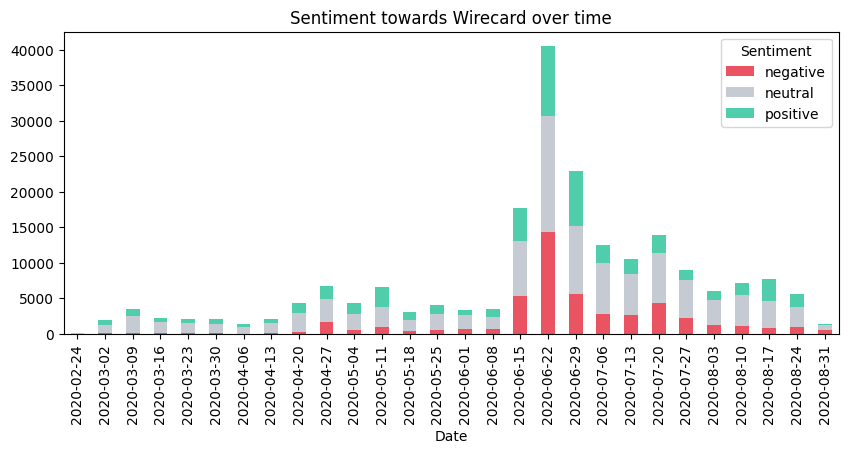

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)
stacked_df.plot.bar(
    stacked=True, 
    ax=ax1,
    color=['#EA5462', '#C5CAD3' ,'#50CEAC']
)
_ = ax1.set_title('Sentiment towards Wirecard over time')

### 2. Sentiment for an entity in relation to a set of key topics

**Use case question**:

- How is the overall sentiment trending towards organisations in my portfolio in relation to a set of key topics? 

**Example**: Sentiment trending around 7 car manufacturers in  January 2021, compared to December 2021, in relation to a set of 6 strategic topics

In [9]:
topic_ids = [
    "fc31abf2-7b11-4ed5-a7d2-35266057c0dd", 
    "c3e9ec2f-e225-4955-9dbf-5480ce3d30fe", 
    "a301b00d-f4ef-49fb-9224-f52386d4955e", 
    "fdcb69a5-8aa6-4067-a29b-f064321e1d7d", 
    "4249987d-5b02-4e51-9c44-019dd8e39742", 
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187"
    ] ## IDs of the following topics: Innovation, Patents & Invention, Corporate Culture, Corporate Governance, Corporate Responsibility, Sustainability

entity_ids = [
    "d6341968-83df-441c-a869-fa7ae9c22c73", 
    "d7f0268d-1322-32b2-83d9-bb6fa9922506", 
    "a9cf01c5-751f-4fe5-a529-12e0d297cb63", 
    "c4ad0758-f3ee-4002-84aa-10849a153d75", 
    "06608104-0136-4371-ad04-be40fcc306a4", 
    "11cab8df-4be1-470f-8f49-8f7f0863ec95", 
    "946b44a8-b767-40ca-8093-e90d6af2a9d4"
    ] ##  IDs of the following car manufacturers: Toyota, Volkswagen, General Motors, Honda, BMW, Tesla, Ford

query = {
    "where": {
        "published-at": {
            "gte": "2020-12-01",
            "lt": "2021-02-01"
        },
        "topics": {
            "id": { "any": topic_ids }
        },
        "entities": {
            "id": { "any": entity_ids }
        }
    },
    "aggregations": {
        # Group by topic, entity and sentiment
        "group-by": [
            "published-at",
            "topic",
            "entity",
            "entity.sentiment"
        ],
        "options": {
            "published-at": { "interval": "month" },
            "topic": { "include": topic_ids },
            "entity": { "include": entity_ids }
        },
        "metrics": ["document-count"]
    }
}

car_manufacturers_result = request(json=query).json()

You can see the structure of the response

In [10]:
json_normalize(car_manufacturers_result, 'aggregations').head()

,published-at,entity.sentiment,document-count,topic.id,topic.name,entity.id,entity.type,entity.name
0,2020-12-01,negative,292,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,a9cf01c5-751f-4fe5-a529-12e0d297cb63,organisation,General Motors
1,2020-12-01,neutral,2263,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,a9cf01c5-751f-4fe5-a529-12e0d297cb63,organisation,General Motors
2,2020-12-01,positive,7939,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,a9cf01c5-751f-4fe5-a529-12e0d297cb63,organisation,General Motors
3,2020-12-01,negative,294,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,d6341968-83df-441c-a869-fa7ae9c22c73,organisation,Toyota
4,2020-12-01,neutral,4010,fc31abf2-7b11-4ed5-a7d2-35266057c0dd,Innovation,d6341968-83df-441c-a869-fa7ae9c22c73,organisation,Toyota


We can convert the date into a data frame for easier processing/transformation

In [11]:
df = json_normalize(car_manufacturers_result, 'aggregations')

df = df.rename(columns={'published-at': 'Date',
                        'entity.sentiment': 'Sentiment', 
                        'document-count': 'Count', 
                        'topic.name': 'Topic', 
                        'entity.name': 'Entity'})

df = df.reindex(columns=[ 'Date', 'Entity', 'Topic', 'Sentiment', 'Count'])
df.style.set_caption('Sentiment breakdown by car manufacturer and topic')
df.head(10)

,Date,Entity,Topic,Sentiment,Count
0,2020-12-01,General Motors,Innovation,negative,292
1,2020-12-01,General Motors,Innovation,neutral,2263
2,2020-12-01,General Motors,Innovation,positive,7939
3,2020-12-01,Toyota,Innovation,negative,294
4,2020-12-01,Toyota,Innovation,neutral,4010
5,2020-12-01,Toyota,Innovation,positive,21248
6,2020-12-01,"Tesla, Inc.",Innovation,negative,639
7,2020-12-01,"Tesla, Inc.",Innovation,neutral,4196
8,2020-12-01,"Tesla, Inc.",Innovation,positive,13383
9,2020-12-01,BMW,Innovation,negative,157


we will now compute a matrix with two dimensions entities and topics for each month containing the overall polarity (which is the total number of positive articles minus the total number of negative articles). 

Then we compute the matrix that shows the trend which is the difference (delta) between the two


In [12]:
def transform_data(some_df):    
    stacked_df = some_df.groupby(['Entity', 'Topic', 'Sentiment']).sum().unstack()
    stacked_df.columns = stacked_df.columns.droplevel(0)

    stacked_df['polarity'] = stacked_df.apply(
        lambda x: x['positive'] - x['negative'],
        axis=1
    )
    reseted_df = stacked_df.reset_index()
    
    return reseted_df.pivot_table(values='polarity', index=reseted_df['Entity'], columns='Topic')

month_data_frames = {
    group: transform_data(date_df.drop(columns=["Date"])) for group, date_df in df.groupby('Date')
}

dec_df = month_data_frames['2020-12-01']
jan_df = month_data_frames['2021-01-01']
trend_df= jan_df.sub(dec_df)
trend_df

Topic,Corporate Governance,Corporate Responsibility,Corporate culture,Innovation,Patents & Inventions,Sustainability
Entity,,,,,,
BMW,-417,1325,13,1920,147,4737
Ford Motor Company,774,596,92,1411,201,2732
General Motors,1252,3339,-16,10552,1283,11449
Honda,127,658,-7,2451,81,-150
"Tesla, Inc.",-227,3581,-1177,7512,18,14014
Toyota,955,-319,-1121,-4016,-1721,-3818
Volkswagen,374,1,-158,189,-86,3439


Now we visualise this matrix

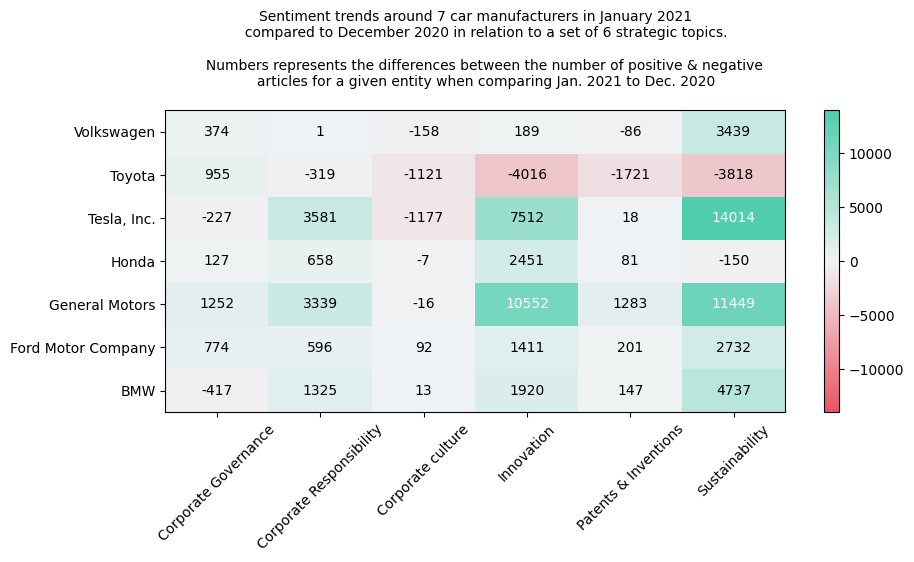

In [13]:
import matplotlib.colors as clr


## helper function to show numeric values in the matplotlib pcolor heatmap
def show_values(pc, fmt="%d", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

# gradient color map from red to grey to green
cmap = clr.LinearSegmentedColormap.from_list('', ['#EA5462','#f0f2f4', '#50CEAC'], N=256)
        
        
fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)

# min and max values for the colors
min_value = trend_df.min().min()
max_value = trend_df.max().max()
abs_max=max(abs(min_value), abs(max_value))

pc = ax1.pcolor(trend_df, vmin=-1*abs_max, vmax=abs_max, cmap=cmap)
show_values(pc)
plt.colorbar(pc)

ax1.set_xticks(np.arange(trend_df.shape[1]) + 0.5, minor=False)
ax1.set_yticks(np.arange(trend_df.shape[0]) + 0.5, minor=False)

ax1.set_xticklabels(list(trend_df.columns), rotation=45)
ax1.set_yticklabels(list(trend_df.index))


_ = ax1.set_title(
    '''Sentiment trends around 7 car manufacturers in January 2021
     compared to December 2020 in relation to a set of 6 strategic topics.
     
     Numbers represents the differences between the number of positive & negative 
     articles for a given entity when comparing Jan. 2021 to Dec. 2020
     '''
)

ax1.title.set_fontsize(10)


### 3. News coverage and sentiment around an entity in different locations

**Use case question**:

- How do news coverage and sentiment around my agency’s clients vary across different countries?

**Example**: Coverage and sentiment around Uber in February 2021 and in 5 different countries

In [14]:
entity_id = "0c20f04a-94ef-467c-921d-f89f8895c41a" ##  ID for Uber
countries = [
    "United States", 
    "United Kingdom", 
    "Germany", 
    "France", 
    "Spain"
    ]

query = {
    "where": {
        "published-at": {
            "gte": "2021-02-01",
            "lt": "2021-03-01"
        },
        # Here we can narrow our search by selecting only the documents where Uber is mentioned
        "entities": {
            "id": {
                "eq": entity_id
            }
        }
    },
    "aggregations": {
        "group-by": [
            "source.country",
            "entity",
            "entity.sentiment"
        ],
        "options": {
            "source.country": { "include": countries },
            "entity": { "include": [entity_id] }
        },
        "metrics": ["document-count"]
    }
}

uber_result = request(json=query).json()

Transform the results into a dataframe for easier processing

In [15]:
json_normalize(uber_result, 'aggregations').head()

,source.country,entity.sentiment,document-count,entity.id,entity.type,entity.name
0,United States,negative,6650,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
1,United States,neutral,27500,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
2,United States,positive,18744,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
3,United Kingdom,negative,3416,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)
4,United Kingdom,neutral,6326,0c20f04a-94ef-467c-921d-f89f8895c41a,organisation,Uber (company)


In [16]:
df = json_normalize(uber_result, 'aggregations')

df = df.rename(columns={'entity.sentiment': 'Sentiment', 'document-count': 'Count', 'source.country': 'Country'})
df = df.reindex(columns=['Country', 'Sentiment', 'Count'])

df.style.set_caption('Sentiment towards Uber in February 2021')


stacked_df = df.groupby(['Country', 'Sentiment']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
stacked_df.head(10)

Sentiment,negative,neutral,positive
Country,,,
France,490,1200,1300
Germany,768,1323,1258
Spain,197,752,571
United Kingdom,3416,6326,2883
United States,6650,27500,18744


Now visualise

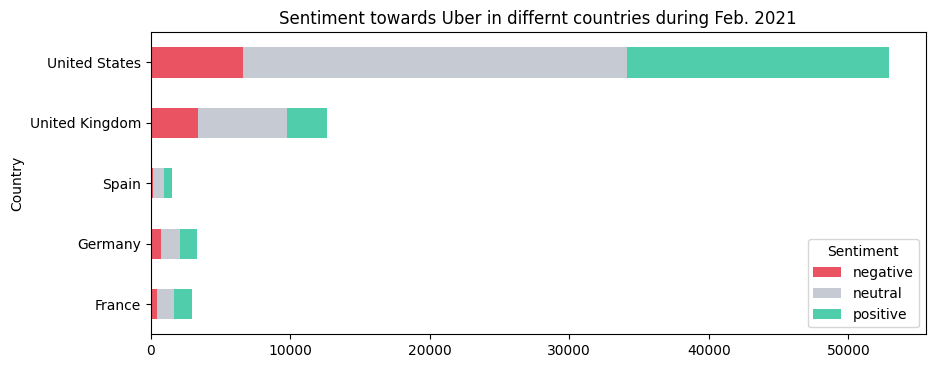

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,4], dpi=100, facecolor='w')
ax1 = plt.subplot(111)
stacked_df.plot.barh(
    stacked=True,
    ax=ax1,
    color=['#EA5462', '#C5CAD3' ,'#50CEAC']
)
_ = ax1.set_title('Sentiment towards Uber in differnt countries during Feb. 2021')

### 4. Difference in coverage and sentiment between entities over time and in relation to different topics

**Use case question**:

- How do different organisations that I monitor compare with respect to coverage and sentiment in relation to key topics?

**Example**: Coverage and sentiment around 4 competitors in the mining industry in the second half of 2020 and in relation to 4 ESG topics

In [18]:
topic_ids = [
    "22297881-a936-4b51-a880-a7152c8ecc68",
    "4249987d-5b02-4e51-9c44-019dd8e39742",
    "8de14dc1-6a93-4d1f-b755-a8d7aa570187",
    "fc31abf2-7b11-4ed5-a7d2-35266057c0dd"
    ] ## IDs of the following topics: Environmental Cleanup, Corporate Controversy,  Sustainability, Chemicals

entity_ids = [
   "72800724-103f-4370-942a-0e715b58ee4a",
   "3d885924-a230-4fac-b17a-d5a1c1151cdf",
   "98eeff9c-6a9a-4d62-801d-eb94b240dd42",
   "592930e0-70fe-45f7-8a1e-ec504158dbf9"
    ] ##  IDs of the following mining companies: Rio Tinto, BHP, Glencore

query = {
    "where": {
        "published-at": {
            "gte": "2020-07-01",
            "lte": "2020-12-31"
        },
        "topics": {
            "id": { "any": topic_ids }
        },
        "entities": {
            "id": { "any": entity_ids }
        }
    },
    "aggregations": {
        "group-by": [
            "published-at",
            "topic",
            "entity",
        ],
        "options": {
            "published-at": { "interval": "week" },
            "topic": { "include": topic_ids },
            "entity": { "include": entity_ids }
        },
        "metrics": ["document-count"]
    }
}

mining_companies_result = request(json=query).json()

In [19]:
json_normalize(mining_companies_result, 'aggregations').head()

,published-at,document-count,topic.id,topic.name,entity.id,entity.type,entity.name
0,2020-06-29,82,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,72800724-103f-4370-942a-0e715b58ee4a,organisation,Rio Tinto Group
1,2020-06-29,37,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,98eeff9c-6a9a-4d62-801d-eb94b240dd42,organisation,Glencore
2,2020-06-29,53,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,592930e0-70fe-45f7-8a1e-ec504158dbf9,organisation,Anglo American plc
3,2020-06-29,42,4249987d-5b02-4e51-9c44-019dd8e39742,Corporate Responsibility,3d885924-a230-4fac-b17a-d5a1c1151cdf,organisation,BHP
4,2020-06-29,37,22297881-a936-4b51-a880-a7152c8ecc68,Environmental Cleanup,592930e0-70fe-45f7-8a1e-ec504158dbf9,organisation,Anglo American plc


In [20]:
df = json_normalize(mining_companies_result, 'aggregations')
df['published-at'] = pd.to_datetime(df['published-at'])

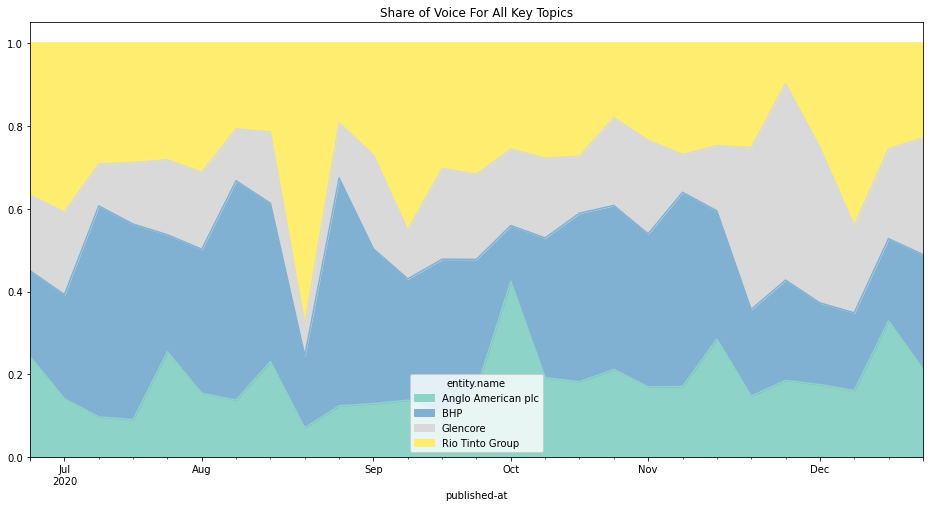

In [21]:
stacked_df = df.groupby(['published-at', 'entity.name']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
_ = stacked_df.divide(stacked_df.sum(axis=1), axis=0).plot.area(
    title='Share of Voice For All Key Topics', 
    figsize=[16,8],
    colormap="Set3"
)

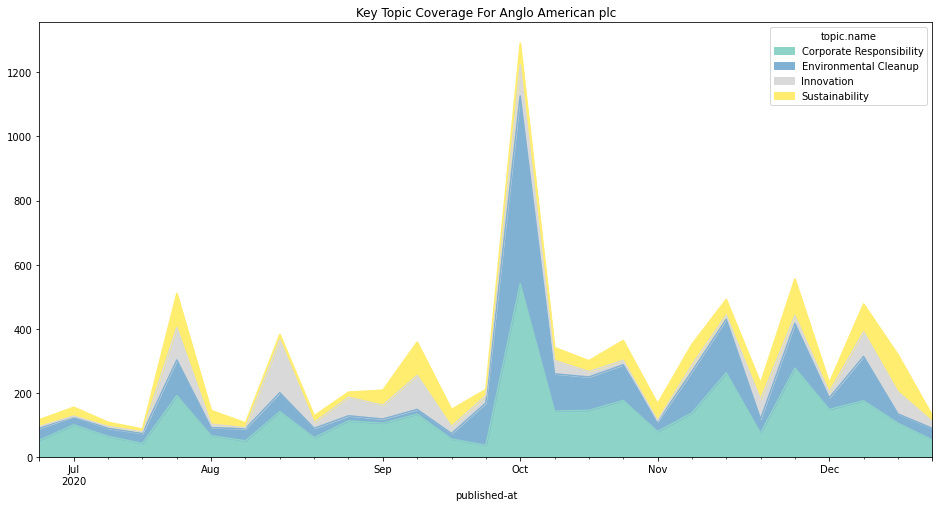

In [22]:
stacked_df = df[df['entity.name'] == 'Anglo American plc'].groupby(['published-at', 'topic.name']).sum().unstack()
stacked_df.columns = stacked_df.columns.droplevel(0)
_ = stacked_df.plot.area(
    title='Key Topic Coverage For Anglo American plc',
    figsize=[16,8],
    colormap="Set3",
)